McSAS-3; notebook version
==
v1: the model and measured intensity are now plain dictionaries instead of Pandas DataFrames. This speeds up the method a lot, by about a factor of 20.

v2: a test has been done to see if it also helps to make the parameterSet a plain dictionary instead of a pandas DataFrame. result: minimal gains of less than a few percent. This effort is stored in McSAS_v2 but reverted. 

v3: back to the original variant with the parameterSet in a DataFrame. This is easier to work with internally and as a result. 

v4: more clean-up and trying Paul Kienzle's even more core model approach (since we're not using polydispersity options on the parameters)

v5: no luck finding those more core approaches, even forcing ocl calculations, no speed improvement was noticed. Anyway, let's 2D fit (because why start with 1D fits?)

In [31]:
# import all the necessary bits and bobs

import h5py, sys
import numpy as np
import pandas
import scipy
import multiprocessing

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use("ggplot")

# change this one to whereever you have the sasmodels installed:
sys.path.append('/Users/brian/Code/sasmodels/')
import sasmodels
import sasmodels.core
import sasmodels.direct_model

In [32]:
# show me all the available models, 1D and 1D+2D

print("\n \n   1D-only SasModel Models:\n")

for model in sasmodels.core.list_models():
    modelInfo = sasmodels.core.load_model_info(model)
    if not modelInfo.parameters.has_2d:
        print("{} is available only in 1D".format(modelInfo.id))

print("\n \n   2D- and 1D- SasModel Models:\n")
for model in sasmodels.core.list_models():
    modelInfo = sasmodels.core.load_model_info(model)
    if modelInfo.parameters.has_2d:
        print("{} is available in 2D".format(modelInfo.id))


 
   1D-only SasModel Models:

adsorbed_layer is available only in 1D
be_polyelectrolyte is available only in 1D
binary_hard_sphere is available only in 1D
broad_peak is available only in 1D
core_multi_shell is available only in 1D
core_shell_sphere is available only in 1D
correlation_length is available only in 1D
dab is available only in 1D
flexible_cylinder is available only in 1D
flexible_cylinder_elliptical is available only in 1D
fractal is available only in 1D
fractal_core_shell is available only in 1D
fuzzy_sphere is available only in 1D
gauss_lorentz_gel is available only in 1D
gaussian_peak is available only in 1D
gel_fit is available only in 1D
guinier is available only in 1D
guinier_porod is available only in 1D
hardsphere is available only in 1D
hayter_msa is available only in 1D
hollow_rectangular_prism_thin_walls is available only in 1D
lamellar is available only in 1D
lamellar_hg is available only in 1D
lamellar_hg_stack_caille is available only in 1D
lamellar_stack_ca

Class definitions:
--

We define several classes here:
  - optimizeScalingAndBackground: takes care of the calculation of the reduced chi-squared value, after a least-squares optimization for the scaling and background factors.
  - McModel: extends the SasModel with information on the parameter set and methods for calculating a total scattering intensity from multiple contributions. It also tracks parameter bounds, random generators and picks.
  - McOpt: contains mostly settings related to the optimization process. Also keeps track of the contribution to optimize.
  - McCore: Contains the methods required to do the optimization. 
  

In [33]:
import mcsas3

In [34]:
from mcsas3.osb import optimizeScalingAndBackground

In [35]:
from mcsas3.mcmodel import McModel

In [36]:
from mcsas3.mcopt import McOpt

In [37]:
from mcsas3.mccore import McCore

1D Tests
== 

The 1D tests load the standard McSAS Quickstartdemo dataset, which is a simulated dataset from a trimodal distribution. 

Speed of a single optimization (~6s) is close to that of McSAS (~6s). After dicking around with the 
optimizeScalingAndBackground fitting bounds, it's increased to 17s.. 

In [38]:
# ok, let's try a more gentle optimization using 1D data :). 
# test with directly imported data

# import data using Pandas
qs = pandas.read_csv("quickstartdemo1.csv", delimiter = ';', header = None, names = ["Q", "I", "ISigma"])
measData = qs.to_dict(orient = "list") # lazy-conversion to dict
measData["Q"] = [np.array(measData["Q"])] # needs to be a list with [Q] or [Qx,Qy]. Q always one-dimensional
measData["I"] = np.array(measData["I"])   # measured intensity, shape must match Q
measData["ISigma"] = np.array(measData["ISigma"]) # uncertainties on the intensiy

import time # I need more time

model = sasmodels.core.load_model('sphere', dtype = "fast") # can't get OpenCV to speed things up...
# kernel = model.make_kernel(measData["Q"])

# track time
t = time.time()

# initialize optimization settings:
mcopt = McOpt(nContrib = 300, maxIter = 1e5, convCrit = 1, nRep = 10)
# make me a model:
mcmod = McModel(
    func = model, seed = 12,
    fitParameterLimits = {"radius": (3, 315)}, 
    staticParameters = {"background": 0, "sld" : 6, "sld_solvent" : 1}
    # staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, }
    )
# tell me the time
print("param prep: {}".format(time.time() - t))
# initialize the core with the model and the optimization settings:
mc = McCore(measData, model = mcmod, opt = mcopt)
# tell me the time
print("McCore prep: {}".format(time.time() - t))
# do one iteration step
mc.iterate()
# tell me the time again...
print("Iterate: {}".format(time.time() - t))
# where are we now:
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
mc.optimize()
mc._model.kernel.release()
print("Final mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))

param prep: 0.007314920425415039
McCore prep: 0.6140339374542236
Iterate: 0.6224708557128906
mc.chisqr: 3904.6990759206546, n accepted: 0
Optimization started
chiSqr: 3904.6990759206546, N accepted: 0 / 1
chiSqr: 147.53566700801122, N accepted: 326 / 1001
chiSqr: 7.520432128279784, N accepted: 504 / 2001
chiSqr: 1.802076527940808, N accepted: 584 / 3001
Final mc.chisqr: 0.9534765949064272, n accepted: 600


In [39]:
model.info.parameters.defaults

{'scale': 1,
 'background': 0,
 'sld': 6,
 'sld_solvent': 1,
 'radius': 50,
 'up:frac_i': 0.0,
 'up:frac_f': 0.0,
 'up:angle': 0.0,
 'M0:sld': 0.0,
 'mtheta:sld': 0.0,
 'mphi:sld': 0.0,
 'M0:sld_solvent': 0.0,
 'mtheta:sld_solvent': 0.0,
 'mphi:sld_solvent': 0.0}

In [40]:
mc._ofname = "test1.h5"

In [41]:
mc._opt.repetition = 0

In [42]:
mc.store()

/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->['radius']]

  exec(code_obj, self.user_global_ns, self.user_ns)


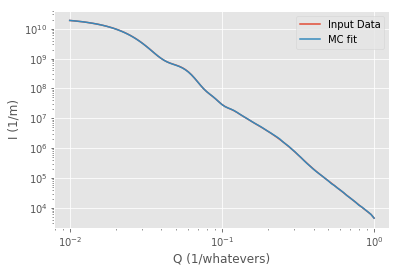

In [43]:
# plot the intensity match:

plt.plot(measData["Q"][0], measData["I"], label = "Input Data")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Q (1/whatevers)")
plt.ylabel("I (1/m)")
plt.plot(measData["Q"][0], mc._opt.modelI * mc._opt.x0[0] + mc._opt.x0[1], label = "MC fit")
plt.legend(loc = 0)

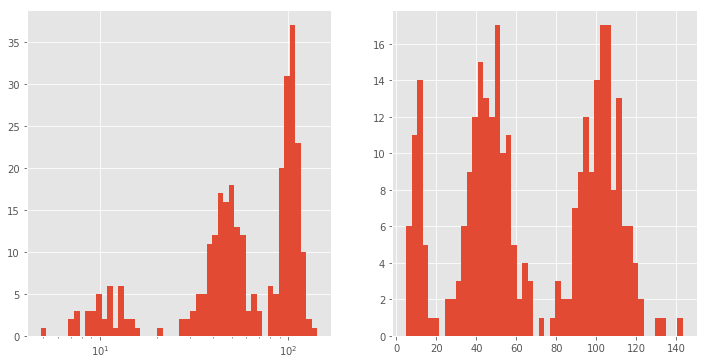

In [49]:
plt.figure(figsize = [12, 6])
# apparently, the SasModels are already volume-weighted!
# plot the size histogram, linear X-axis for now..
plt.subplot(121)
binEdges = np.logspace(
    np.log10(mc._model.parameterSet["radius"].min()),
    np.log10(mc._model.parameterSet["radius"].max()),
    51
)
plt.hist(list(mc._model.parameterSet["radius"]), bins = binEdges, log = False)
plt.xscale("log")
plt.subplot(122)

_ = plt.hist(list(mc._model.parameterSet["radius"]), bins = 50, log = False)
# that one looks exactly the same as the McSAS fits. so yes, SasModels are V-compensated by default...

Until here, everything works...
==

(but check out the 2D data fitting below, which partially works!)

In [10]:
# all separate instances, but producing the same result. random needs seed?
# model = sasmodels.core.load_model('sphere', dtype = "fast")


def runit(seed):
    # # it runs with a single kernel, but I'm a bir afraid of cross-talk between the instances and volume calculations..
    model = sasmodels.core.load_model('sphere', dtype = "fast", platform = "ocl")
    # kernel = model.make_kernel(measData["Q"])
    mcopt = McOpt(nContrib = 300, maxIter = 1e5, convCrit = 1, nRep = 10)
    mcpar = McModel(
        func = model, seed = seed,
        fitParameterLimits = {"radius": (3, 315)}, 
        staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, })
    mc = McCore(measData, model = mcpar, opt = mcopt)
    mc._OSB.xBounds = ([0, 1e7], [-1e4, 1e4])
    mc.optimize()
    mc._model.kernel.release()
    return mc._model.parameterSet

runit(1)
# Pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
# mapParam = [i for i in range(int(10))]
# rawData = Pool.map(runit, mapParam) 

Optimization started
chiSqr: 4161.854578255158, N accepted: 0 / 0
chiSqr: 4161.854578255158, N accepted: 0 / 1
chiSqr: 141.17766238578335, N accepted: 362 / 1001
chiSqr: 15.199812210469265, N accepted: 516 / 2001
chiSqr: 2.8216735723063766, N accepted: 608 / 3001
chiSqr: 1.3046053720971629, N accepted: 645 / 4001


,radius
0,47.6752
1,63.6512
2,26.4102
3,75.2911
4,48.7878
5,31.8096
6,6.61595
7,121.487
8,98.903
9,100.428


In [17]:
# Paul suggested doing it this way.. doesn't work..

sasmodels.direct_model.DirectModel
kernel1 = sasmodels.direct_model.DirectModel(measData["Q"], model)

AttributeError: 'list' object has no attribute 'x'

In [18]:
# continuation of Paul's suggestions:

parameters = kernel.info.parameters
mesh = [(np.nan, np.nan, 1.0) for p in parameters.call_parameters]
call_details, values, magnetic = sasmodels.direct_model.make_kernel_args(kernel, mesh)
call_details.show(values)

NameError: name 'kernel' is not defined

In [27]:
# continuation of Paul's suggestions:
# Set up parameter vectors with NaN placeholders for the parameter set
parameters = kernel.info.parameters
mesh = [(NaN, NaN, 1.0) for p in parameters.call_parameters]
call_details, values, magnetic = make_kernel_args(kernel, mesh)
call_details.show(values)

# generate views on the values vector to make it easier to assign parameter sets
value_vec = values[0:parameters.nvalues]
dist_vec = values[parameters.nvalues:parameters.nvalues + call_details.num_weights]

# Loop over the monte carlo parameter sets, calling the kernel for each one.
Iq = np.zero(kernel.q_input.nq)
for parameter_set in monte_carlo(n):
   # scale, background in values[0], values[1]
   value_vec[:] = parameter_set
   dist_vec[:] = parameter_set
   Iq += kernel(call_details, values, cutoff, magnetic)
Iq /= n


In [9]:
#openCL?

import pyopencl
%load_ext pyopencl.ipython_ext

In [22]:
# all separate instances, but producing the same result. random needs seed?
# model = sasmodels.core.load_model('sphere', dtype = "fast")

# no longer works??? somehow things get stuck in a wait loop now. 
model = sasmodels.core.load_model('sphere', dtype = "fast", platform = "ocl")

def runit(seed):
    # # it runs with a single kernel, but I'm a bir afraid of cross-talk between the instances and volume calculations..
    # kernel = model.make_kernel(measData["Q"])
    mcopt = McOpt(nContrib = 300, maxIter = 1e5, convCrit = 1, nRep = 10)
    mcpar = McModel(
        func = model, seed = seed,
        fitParameterLimits = {"radius": (3, 315)}, 
        staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, })
    mc = McCore(measData, model = mcpar, opt = mcopt)
    mc.optimize()
    self._model.kernel.release()
    return mc._model.parameterSet

Pool = multiprocessing.Pool(processes = multiprocessing.cpu_count())
mapParam = [i for i in range(int(10))]
rawData = Pool.map(runit, mapParam) 

Process ForkPoolWorker-13:
Process ForkPoolWorker-14:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/brian/anaconda3/envs/notebook3/lib/python3.6/multiprocessing/process.py", 

KeyboardInterrupt: 

In [13]:
t = time.time()
for n in range(1000):
    mc.iterate()
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
print("Iterate: {} s".format(time.time() - t))

mc.chisqr: 0.8696311968213971, n accepted: 621
Iterate: 3.261826276779175 s


2D Test
-- 

For this test, we use one of Qais' datasets. This is a dataset from magnetically-oriented pearl strings. 

In [50]:
# test with directly imported data
with h5py.File("20180503_13_raw_expanded_stacked_processed_180507_125408.nxs", 'r') as h5f:
    I = h5f['/entry/result/data'].value.squeeze()
    ISigma = h5f['/entry/result/errors'].value.squeeze()
    Qx = h5f['/entry/result/Q-space (inverse Angstrom)'].value
    Qy = h5f['/entry/result/Q-space (inverse Angstrom)1'].value
with h5py.File("Mask conf 3.nxs", 'r') as h5f:
    mask = h5f['/entry/mask/mask'].value.squeeze()
newMask = ((I<-500) | mask)
newMask = newMask.astype(bool)

posNeg = np.sign(np.diff(Qx))
posNeg = np.append(posNeg, posNeg[-1])
Qx = Qx * posNeg

posNeg = np.sign(np.diff(Qy))
posNeg = np.append(posNeg, posNeg[-1])
Qy = Qy * posNeg

Q0 = Qx[:, np.newaxis] + 0 * Qy[np.newaxis, :]
Q1 = 0 * Qx[:, np.newaxis] + Qy[np.newaxis, :]

a0l, a0h, a1l, a1h = 300, 500, 400, 600
# a0l, a0h, a1l, a1h = 200, 600, 300, 700
measData = dict()
measData["IOrig"] = (I / np.invert(newMask))[a0l: a0h, a1l: a1h]
measData["kansas"] = measData["IOrig"].shape
measData["IOrig"] = np.reshape(measData["IOrig"], measData["IOrig"].size)
measData["ISigmaOrig"] = (ISigma / np.invert(newMask))[a0l: a0h, a1l: a1h]
measData["ISigmaOrig"] = np.reshape(measData["ISigmaOrig"], measData["ISigmaOrig"].size)
measData["QOrig"] = [
    np.reshape((Q0 / np.invert(newMask))[a0l: a0h, a1l: a1h], measData["ISigmaOrig"].size),
    np.reshape((Q1 / np.invert(newMask))[a0l: a0h, a1l: a1h], measData["ISigmaOrig"].size)]

bArr = np.invert((np.isinf(measData["IOrig"])|(measData["ISigmaOrig"] == 0)))
measData["I"] = measData["IOrig"][bArr]
measData["ISigma"] = measData["ISigmaOrig"][bArr]
measData["Q"] = [measData["QOrig"][0][bArr], measData["QOrig"][1][bArr]]

/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


In [61]:
Qy.shape

(1030,)

In [52]:
import time
nContrib = 300

model = sasmodels.core.load_model('ellipsoid', dtype = "fast")
kernel = model.make_kernel(measData["Q"])

t = time.time()
mcopt = McOpt(nContrib = 600)
mcopt.maxAccept = 100000
mcopt.maxIter = 100000
mcopt.convCrit = 1

mcpar = McModel(
    func = model, 
    fitParameterLimits = {"radius_equatorial": (1, 300), 
                          "radius_polar": (300, 3000), 
                          "phi": (90-90, 90+90)}, 
    staticParameters = {"background": 0, "theta": 90.1,
                        "sld" : 1, "sld_solvent" : 0, "scale": 1 })
print("param prep: {}".format(time.time() - t))
mc = McCore(measData, model = mcpar, opt = mcopt)
print("McCore prep: {}".format(time.time() - t))
mc.iterate()
print("Iterate: {}".format(time.time() - t))
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))

# mc._modelParameters.parameterSet.loc[0].to_dict()

param prep: 0.00032210350036621094
McCore prep: 2.0275309085845947
Iterate: 2.48655104637146
mc.chisqr: 32.4252784393897, n accepted: 1


In [53]:
mc._model.parameterSet.loc[0].to_dict()

{'radius_equatorial': 98.09470043041858,
 'radius_polar': 1443.774644006324,
 'phi': 167.12747001968958}

In [54]:
t = time.time()
for contribi in range(300):
    sasmodels.direct_model.call_kernel(kernel, mc._model.parameterSet.loc[contribi].to_dict())
time.time()-t

0.5981287956237793

In [55]:
# %%timeit
# mc.iterate()

In [56]:
mc.optimize()

Optimization started
chiSqr: 32.4252784393897, N accepted: 1 / 1
chiSqr: 13.610042402474393, N accepted: 432 / 1001
chiSqr: 7.072222403048225, N accepted: 694 / 2001
chiSqr: 4.085497474789954, N accepted: 897 / 3001
chiSqr: 2.770163855460031, N accepted: 1045 / 4001
chiSqr: 2.2462127489697044, N accepted: 1154 / 5001
chiSqr: 2.04636435726103, N accepted: 1219 / 6001
chiSqr: 1.9504990395849784, N accepted: 1268 / 7001
chiSqr: 1.9142752931461537, N accepted: 1302 / 8001
chiSqr: 1.8649608716895298, N accepted: 1343 / 9001
chiSqr: 1.8394871767401042, N accepted: 1377 / 10001
chiSqr: 1.8171046399881725, N accepted: 1408 / 11001
chiSqr: 1.7994153673688522, N accepted: 1430 / 12001
chiSqr: 1.789406622837073, N accepted: 1445 / 13001
chiSqr: 1.784751423780945, N accepted: 1463 / 14001
chiSqr: 1.7715953365875172, N accepted: 1480 / 15001
chiSqr: 1.7677507800955221, N accepted: 1490 / 16001
chiSqr: 1.761391626181134, N accepted: 1503 / 17001
chiSqr: 1.757880149706647, N accepted: 1512 / 18001
ch

KeyboardInterrupt: 

7057.020623123988

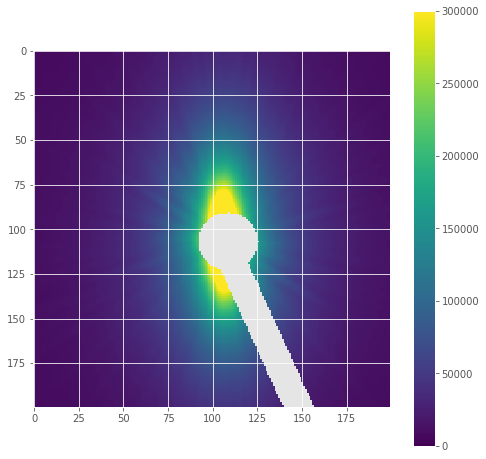

In [57]:
plt.figure(figsize = [8,8])
modelData = dict()
modelData["Q"] = measData["QOrig"]
modelData["I"] = measData["IOrig"]
bArr = np.invert((np.isinf(measData["IOrig"])|(measData["ISigmaOrig"] == 0)))
modelData["I"][bArr] = mc._opt.modelI
modelData["I"] = modelData["I"].reshape(measData["kansas"])
plt.imshow((modelData["I"] * mc._opt.x0[0] + mc._opt.x0[1]), vmin = 0, vmax = 3e5)
plt.colorbar()
mc._opt.x0[1]

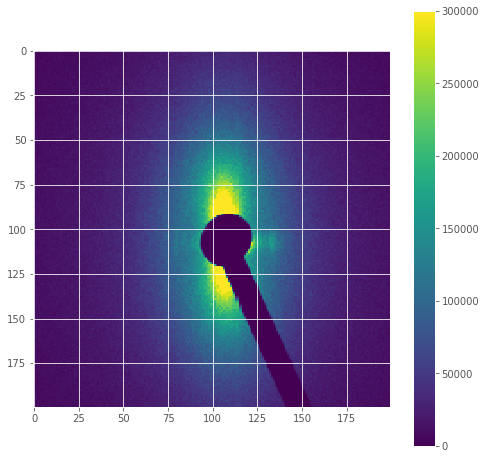

In [58]:
plt.figure(figsize = [8,8])
plt.imshow(I[a0l: a0h, a1l: a1h], vmin = 0, vmax = 3e5)
plt.colorbar()

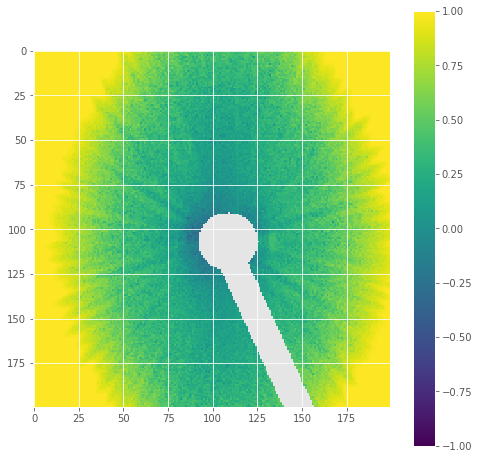

In [59]:
plt.figure(figsize = [8,8])
plt.imshow((I[a0l: a0h, a1l: a1h] - modelData["I"] * mc._opt.x0[0] + mc._opt.x0[1])/I[a0l: a0h, a1l: a1h], vmin = -1, vmax = 1)
plt.colorbar()

(array([11., 10., 11., 13., 12., 12., 12., 15., 13., 17., 26., 22., 34.,
        40., 47., 47., 40., 32., 28., 23., 18., 13., 16., 10., 14., 15.,
        10., 13., 13., 13.]),
 array([  0.18105448,   6.16987327,  12.15869206,  18.14751085,
         24.13632964,  30.12514843,  36.11396722,  42.102786  ,
         48.09160479,  54.08042358,  60.06924237,  66.05806116,
         72.04687995,  78.03569874,  84.02451753,  90.01333631,
         96.0021551 , 101.99097389, 107.97979268, 113.96861147,
        119.95743026, 125.94624905, 131.93506784, 137.92388662,
        143.91270541, 149.9015242 , 155.89034299, 161.87916178,
        167.86798057, 173.85679936, 179.84561814]),
 <a list of 30 Patch objects>)

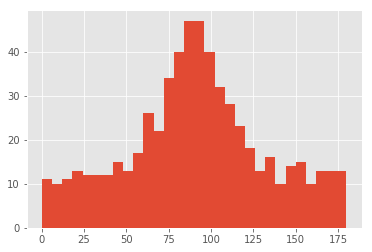

In [63]:
plt.hist(list(mc._model.parameterSet.phi.values), bins = 30)

In [21]:
mc._opt.convCrit

1

In [22]:
mc._OSB.match(mc._opt.modelI, [1, 1])

(array([1.34515307e+01, 1.75222234e+04]), 20.94112966244663)

In [23]:
plt.imshow((mc._OSB.measDataISigma==0).reshape(measData["kansas"]))

ValueError: cannot reshape array of size 37840 into shape (200,200)

In [24]:
plt.imshow(mc._opt.modelI.reshape(measData["kansas"]))

ValueError: cannot reshape array of size 37840 into shape (200,200)

In [555]:
# plt.imshow(mc._opt.modelI.reshape(measData["kansas"]))
mc._opt.testX0

array([1., 0.])

In [314]:
%%timeit
sasmodels.direct_model.call_kernel(kernel, dict(radius=3.1416, background = 0))

1.17 ms ± 40.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [315]:
%%timeit
mc.reEvaluate()

/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


240 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [317]:
t = time.time()
for n in range(10):
    mc.iterate()
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
print("Iterate: {} s".format(time.time() - t))


/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/brian/anaconda3/envs/notebook3/lib/python3.6/site-packages/scipy/optimize/optimize.py:663: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


mc.chisqr: nan, n accepted: 0
Iterate: 2.524678945541382 s


In [316]:
mc._opt.x0

array([ 6968.98184328, 44215.46436466])

In [300]:
t = time.time()
mc.optimize()
print("mc.chisqr: {}, n accepted: {}".format(mc._opt.gof, mc._opt.accepted))
print("optimization: {} s".format(time.time() - t))



Optimization started
chiSqr: nan, N accepted: 0 / 11


TypeError: '<' not supported between instances of 'int' and 'NoneType'

Other trials
-- 
Generation of a 2D intensity...

{'scale': 1, 'background': 0.001, 'sld': 4, 'sld_solvent': 1, 'radius_polar': 20, 'radius_equatorial': 400, 'theta': 60, 'phi': 60, 'up:frac_i': 0.0, 'up:frac_f': 0.0, 'up:angle': 0.0, 'M0:sld': 0.0, 'mtheta:sld': 0.0, 'mphi:sld': 0.0, 'M0:sld_solvent': 0.0, 'mtheta:sld_solvent': 0.0, 'mphi:sld_solvent': 0.0}
{'scale': 1, 'background': 0.001, 'sld': 4, 'sld_solvent': 1, 'radius_polar': 15, 'radius_equatorial': 400, 'theta': 60, 'phi': 60, 'up:frac_i': 0.0, 'up:frac_f': 0.0, 'up:angle': 0.0, 'M0:sld': 0.0, 'mtheta:sld': 0.0, 'mphi:sld': 0.0, 'M0:sld_solvent': 0.0, 'mtheta:sld_solvent': 0.0, 'mphi:sld_solvent': 0.0}
q2x.shape: (240000,), q2z.shape: (240000,)


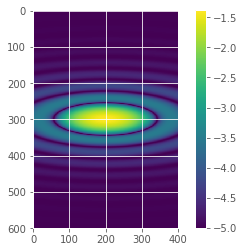

In [143]:
# documentation example on how to calculate a 2D pattern:

model = sasmodels.core.load_model('ellipsoid')
print("{}".format(model.info.parameters.defaults))
model.info.parameters.defaults.update({"radius_polar": 15})
print("{}".format(model.info.parameters.defaults))
qx = np.linspace(-2, 2, 400) # linear
qz = np.linspace(-3, 3, 600) # linear 
q2x = qx + 0 * qz[:, np.newaxis] # make rectangular
q2z = qz[:, np.newaxis] + 0 * qx # make rectangular
kansas = q2x.shape # save original shape
q2x = q2x.reshape(q2x.size) # flatten
q2z = q2z.reshape(q2z.size) # flatten
print("q2x.shape: {}, q2z.shape: {}".format(q2x.shape, q2z.shape))
kernel = model.make_kernel([q2x, q2z]) # feed to kernel
# theta is perpendicularity of cylinder with the beam
# phi = 90, cylinder is "vertical"
Iq = sasmodels.direct_model.call_kernel(kernel, dict(
    radius_equatorial=3.1416, radius_polar = 10, background = 1e-5, theta = 90,
    phi = 90, sld = 1, sld_solvent = 0, 
))
Iq = Iq.reshape(kansas) # move back to original shape
plt.imshow(np.log10(Iq)) # plot
plt.colorbar() 
model.release() # free up space in (GPU) memory

Test of normal least-squares optimization:
--

In [669]:
qs = pandas.read_csv("quickstartdemo1.csv", delimiter = ';', header = None, names = ["Q", "I", "ISigma"])
measData = qs.to_dict(orient = "list")
measData["Q"] = [np.array(measData["Q"])]

measData["I"] = np.array(measData["I"])
measData["ISigma"] = np.array(measData["ISigma"])

model = sasmodels.core.load_model('sphere', dtype = "fast")
kernel = model.make_kernel(measData["Q"])

mcpar = McModel(
    func = model, 
    fitParameterLimits = {"radius": (3, 315)}, 
    staticParameters = {"background": 0, "sld" : 1, "sld_solvent" : 0, })

def optFunc(x, kernel, measDataI, measDataISigma):
    # apply positive bounds to scaling and radius
    x[0], x[2] = np.abs(x[0]), np.abs(x[2])
    modelI = sasmodels.direct_model.call_kernel(
                kernel, 
        {'scale': x[0], 'background': x[1], 'radius': x[2]}
    )
    cs = sum(
        ((measDataI - modelI)/measDataISigma)**2
    ) / measDataI.size
    return cs

opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "Nelder-Mead",
                        args = (kernel, measData["I"], measData["ISigma"]),)
                        # bounds = [(0, None), 
                        #           (0, None), (0, None)])



In [670]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "Powell",
                        args = (kernel, measData["I"], measData["ISigma"]),)

41.8 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [671]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "Nelder-Mead",
                        args = (kernel, measData["I"], measData["ISigma"]),)

82.6 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [672]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "CG",
                        args = (kernel, measData["I"], measData["ISigma"]),)

1.34 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [673]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "BFGS",
                        args = (kernel, measData["I"], measData["ISigma"]),)

1.32 ms ± 22.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [674]:
%%timeit
opt = scipy.optimize.minimize(optFunc, 
                        x0 = [1e8, .5, 12], 
                        method = "TNC",
                        args = (kernel, measData["I"], measData["ISigma"]),)

2.83 ms ± 423 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [675]:
opt

 final_simplex: (array([[3.19382903e+06, 9.27543685e-01, 7.22338484e+01],
       [3.19382903e+06, 9.27543685e-01, 7.22338484e+01],
       [3.19382903e+06, 9.27543685e-01, 7.22338484e+01],
       [3.19382903e+06, 9.27543685e-01, 7.22338484e+01]]), array([3313.45435733, 3313.45435733, 3313.45435733, 3313.45435733]))
           fun: 3313.4543573342135
       message: 'Optimization terminated successfully.'
          nfev: 300
           nit: 128
        status: 0
       success: True
             x: array([3.19382903e+06, 9.27543685e-01, 7.22338484e+01])

In [676]:
modelI = sasmodels.direct_model.call_kernel(
                kernel, 
        {'scale': opt.x[0], 'background': opt.x[1], 'radius': opt.x[2]}
    )

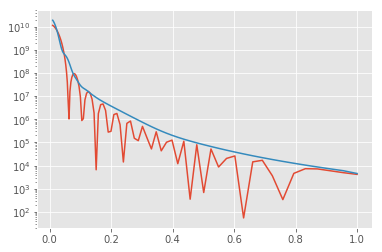

In [677]:
plt.plot(measData["Q"][0], modelI)
plt.plot(measData["Q"][0], measData["I"])
plt.yscale("log")

In [14]:
a = model.info.parameters.defaults.copy()

In [15]:
a.update({"fish": "king"})

In [16]:
a

{'scale': 1,
 'background': 0,
 'sld': 1,
 'sld_solvent': 0,
 'radius': 50,
 'up:frac_i': 0.0,
 'up:frac_f': 0.0,
 'up:angle': 0.0,
 'M0:sld': 0.0,
 'mtheta:sld': 0.0,
 'mphi:sld': 0.0,
 'M0:sld_solvent': 0.0,
 'mtheta:sld_solvent': 0.0,
 'mphi:sld_solvent': 0.0,
 'fish': 'king'}

In [20]:
%%timeit
dict(a, **{"boo": "la"})

770 ns ± 12.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
